In [4]:
# import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce
import pickle
import json

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

# import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

In [5]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

In [6]:
print(sys.version_info)
print(pd.__version__)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
0.24.2


In [7]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
metjet_plot_vars = all_plot_vars[0:4] # ['metpt', 'jetpt', 'metjetphi', 'metmuphi']
muons_plot_vars = all_plot_vars[4:8] # ['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]'
]

In [13]:
with open('config/sig.json') as sigs_json_file:
    sigs = json.load(sigs_json_file)

In [14]:
with open('config/bkgs.json') as bkgs_json_file:
    bkgs = json.load(bkgs_json_file)

# Global muons

In [16]:
luminosity = 59.97 * 1000 # 1/pb
for sig, properties in sigs.items():
    try:
        properties['weight'] = luminosity * properties['xsec'] / histos_signal_from_file_gbm['sumgenwgt'][sig]
    except KeyError:
        properties['weight'] = 1
        
histos = {}
for plot_var in histos_signal_from_file_gbm:
    try:
        histos[plot_var] = {**histos_signal_from_file_gbm[plot_var], **histos_signal_from_file_gbm[plot_var]}
    except KeyError:
        histos[plot_var] = histos_signal_from_file_gbm[plot_var]

In [17]:
with open('data/histos_bkgs_objects_gbm.dat', 'rb') as file:
#with open('histos_bkgs_objects_gbm.dat', 'rb') as file:
    histos_bkgs_from_file_gbm = pickle.load(file)

In [11]:
histos_bkgs_from_file_gbm['sumgenwgt']

{'DYJetsToLL': 208972.9140625,
 'QCD_bEnriched_HT100to200': 553052.03125,
 'QCD_bEnriched_HT200to300': 377154.5625,
 'QCD_bEnriched_HT300to500': 1065600.875,
 'QCD_bEnriched_HT500to700': 377873.140625,
 'QCD_bEnriched_HT700to1000': 244473.546875,
 'QCD_bEnriched_HT1000to1500': 491976.78125,
 'QCD_bEnriched_HT1500to2000': 409126.46875,
 'QCD_bEnriched_HT2000toINF': 396573.375,
 'TTTo2L2Nu': 22335856.0,
 'TTJets': 240559.4453125,
 'TT_diLept': 114101496.0,
 'WJetsToLNu_HT-70To100': 203239.6796875,
 'WJetsToLNu_HT-100To200': 268146.140625,
 'WJetsToLNu_HT-200To400': 395361.265625,
 'WJetsToLNu_HT-400To600': 1895963.5625,
 'ZJetsToNuNu_HT-100To200': 197944.59375,
 'ZJetsToNuNu_HT-200To400': 610673.78125,
 'ZJetsToNuNu_HT-400To600': 221007.59375,
 'ZJetsToNuNu_HT-600To800': 206165.875,
 'ZJetsToNuNu_HT-800To1200': 298636.390625,
 'ZJetsToNuNu_HT-1200To2500': 340171.0,
 'ZJetsToNuNu_HT-2500ToInf': 350168.84375,
 'WWJJToLNuLNu': 493681.71875,
 'WWTo2L2Nu': 1456916.0,
 'WZTo3LNu': 58717.921875

In [12]:
luminosity = 59.97 * 1000 # 1/pb
for bkg, properties in bkgs.items():
    try:
        properties['weight'] = luminosity * properties['xsec'] / histos_bkgs_from_file_gbm['sumgenwgt'][bkg]
    except KeyError:
        properties['weight'] = 1

In [13]:
histos = {}
for plot_var in histos_bkgs_from_file_gbm:
    try:
        histos[plot_var] = {**histos_bkgs_from_file_gbm[plot_var], **histos_signal_from_file_gbm[plot_var]}
    except KeyError:
        histos[plot_var] = histos_bkgs_from_file_gbm[plot_var]

In [20]:
# Conversion from dict file into objects
# Shouldn't need this unless recovering from a broken Jupyter session
# histos_gbm = {}
# for var in histos_from_file_gbm:
#     histos_gbm[var] = {}
#     if 'cutflow' in var or 'genwgt' in var:
#         for bkg in histos_from_file_gbm[var]:
#             histos_gbm[var][bkg] = histos_from_file_gbm[var][bkg]
#     else:
#         for bkg in histos_from_file_gbm[var]:
#             histos_gbm[var][bkg] = HCont.HistogramContainer(bins=len(histos_from_file_gbm[var][bkg]['counts'][0]))
#             histos_gbm[var][bkg] += list(zip(histos_from_file_gbm[var][bkg]['counts'].values(),
#                                       {cut:histos_from_file_gbm[var][bkg]['edges'] for cut in numCuts}.values(),
#                                       histos_from_file_gbm[var][bkg]['wgt_sqrd'].values()))

### Cutflow table

In [21]:
cutflow_incl_grps = {}
for sig, properties in sigs.items():
    grp = properties['group']
    if grp not in cutflow_incl_grps:
        cutflow_incl_grps[grp] = (histos_signal_from_file_gbm['cutflow_incl'][sig]*properties['weight']).astype(int)
    else:
        cutflow_incl_grps[grp] += (histos_signal_from_file_gbm['cutflow_incl'][sig]*properties['weight']).astype(int)
        
# for mchi in ['5p25', '6p0', '52p5', '60p0']:
#     cutflow_incl_grps[mchi] = histos_signal_from_file_gbm['cutflow_incl'][mchi].astype(int)
        
pd.DataFrame.from_dict(cutflow_incl_grps)

,sig
0,5123836800
1,1381870027
2,1219462634
3,510350687
4,258083645
5,258083645
6,258083645
7,181972430
8,100498372
9,47526467


In [22]:
pd.DataFrame.from_dict(dict(sorted(histos['cutflow_incl'].items())))

ValueError: arrays must all be same length

In [ ]:
cutflow_incl_grps = {}
for bkg, properties in bkgs.items():
    grp = properties['group']
    if grp not in cutflow_incl_grps:
        cutflow_incl_grps[grp] = (histos_bkgs_from_file_gbm['cutflow_incl'][bkg]*properties['weight']).astype(int)
    else:
        cutflow_incl_grps[grp] += (histos_bkgs_from_file_gbm['cutflow_incl'][bkg]*properties['weight']).astype(int)
        
# for mchi in ['5p25', '6p0', '52p5', '60p0']:
#     cutflow_incl_grps[mchi] = histos_signal_from_file_gbm['cutflow_incl'][mchi].astype(int)
        
pd.DataFrame.from_dict(cutflow_incl_grps)

In [ ]:
pd.DataFrame.from_dict(dict(sorted(histos['cutflow_incl'].items())))

### Plots

In [14]:
def plot_binned_data_error(axis, bin_edges, data, wgt_sqrd, *args, **kwargs):
#     errors = []
    weights = np.empty(len(data))
#     errors = np.sqrt(np.sum(wgt_sqrd, axis=0))
    errors = wgt_sqrd[0]
    for i in np.arange(1, len(wgt_sqrd)):
        errors = errors.add(wgt_sqrd[i], fill_value=0)
    errors = errors.reindex(np.arange(1, len(bin_edges)), fill_value=0)
    errors = np.sqrt(errors)
    binwidth = bin_edges[1] - bin_edges[0]
#         if 'density' in kwargs and kwargs['density'] == True:
#             errors = errors/np.sum(data)/binwidth
        #The dataset values are the bin centres
    x = (bin_edges[1:] + bin_edges[:-1]) / 2.0
        #The weights are the y-values of the input binned data
#         weights[i] = data[i]
    return skh_plt.hist(x, ax=axis, bins=bin_edges, weights=np.sum(data, axis=0), errorbars=errors, *args, **kwargs)

In [15]:
def plot_stacked_binned_data(axis, bin_edges, data, wgt_sqrd, *args, **kwargs):
    errors = wgt_sqrd[0]
    for i in np.arange(1, len(wgt_sqrd)):
        errors = errors.add(wgt_sqrd[i], fill_value=0)
    errors = np.sqrt(errors)
    errors = np.array(errors.reindex(np.arange(1, len(bin_edges)), fill_value=0))
    #The dataset values are the bin centres
    x = (bin_edges[1:] + bin_edges[:-1]) / 2.0
    x = np.array([x]).repeat(len(data), axis=0)
    x = np.transpose(x)
    #The weights are the y-values of the input binned data
    weights = np.transpose(data)
    return skh_plt.hist(x, ax=axis, bins=bin_edges, weights=weights, errorbars=errors, stacked=True, *args, **kwargs)

In [16]:
from skhep.visual import MplPlotter as skh_plt

In [17]:
from collections import OrderedDict

In [ ]:
plot_var = 'metjetphi'
cut=0
labels = []
grp_histos = {}
for bkg, properties in bkgs.items():
    grp = properties['group']
    if grp not in grp_histos:
        grp_histos[grp] = HCont.HistogramContainer()
    # self.histos[plot_var][bkg].set_weight(properties['weight'])
    # FIXME placeholder while H.C. doesn't have set_weight
    grp_histos[grp].counts[cut] += histos[plot_var][bkg].counts[cut] * properties['weight']
    grp_histos[grp].edges = histos[plot_var][bkg].edges
    grp_histos[grp].wgt_sqrd[cut] = grp_histos[grp].wgt_sqrd[cut].add(
        histos[plot_var][bkg].wgt_sqrd[cut] * properties['weight']**2, fill_value=0)
    
sorted_keys = sorted(grp_histos, key=lambda obj: max(grp_histos[obj].counts[0]))
sorted_grp_histos = OrderedDict()
for key in sorted_keys:
#     if 'DY' not in key: continue
    sorted_grp_histos[key] = grp_histos[key]
    labels.append(key)

fig, axis = plt.subplots()
plot_stacked_binned_data(axis, histos['metjetphi']['ZZTo2L2Nu'].edges,
                       np.array([sorted_grp_histos[grp].counts[0] for grp in sorted_grp_histos]),
                      [sorted_grp_histos[grp].wgt_sqrd[0] for grp in sorted_grp_histos], label=labels);

axis.set_yscale('log', nonposy='clip')
# axis.set_ylim(bottom = 1)

axis.legend()

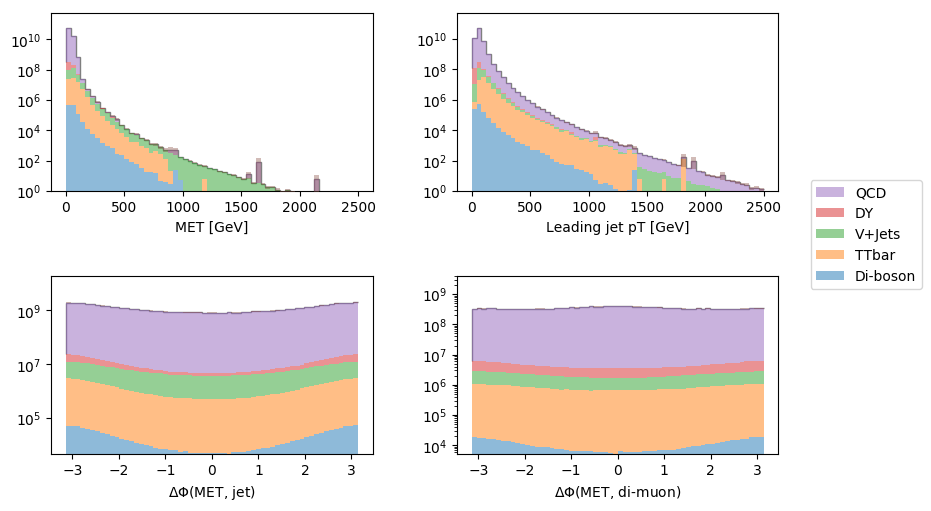

In [26]:
plt_maker = PM.PlotMaker(histos, bkgs)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)

for idx, var in enumerate(metjet_plot_vars):
    plt_maker.make_group_stacked_plot(axes1.flatten()[idx], var, 0, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
    
axes1[0,1].legend(loc=(1.1,-0.55));

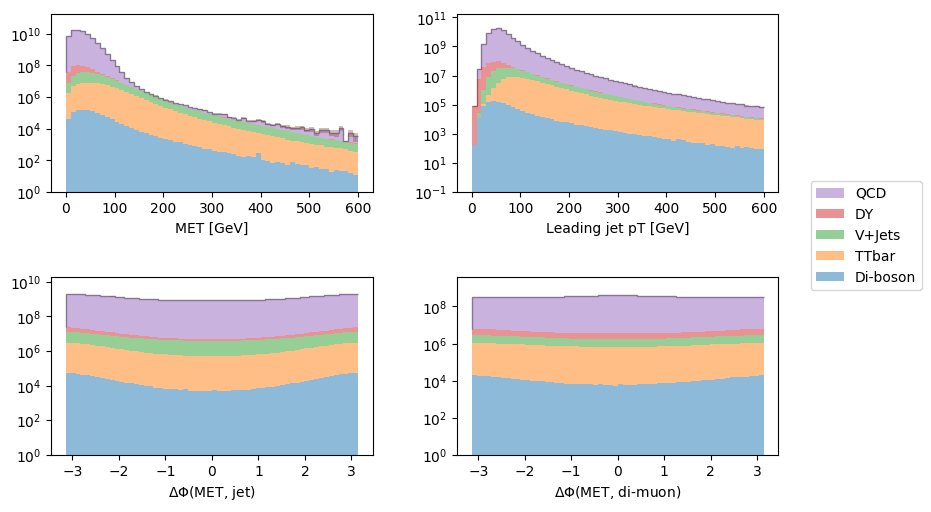

In [375]:
plt_maker = PM.PlotMaker(histos, bkgs)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)

for idx, var in enumerate(metjet_plot_vars):
    plt_maker.make_group_stacked_plot(axes1.flatten()[idx], var, 0, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
    
axes1[0,1].legend(loc=(1.1,-0.55));

In [6]:
plt_maker = PM.PlotMaker(histos, bkgs, ['5p25', '60p0'])

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)

for idx, var in enumerate(metjet_plot_vars):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
    
axes1[0,1].legend(loc=(1.1,-0.55));

NameError: name 'PM' is not defined

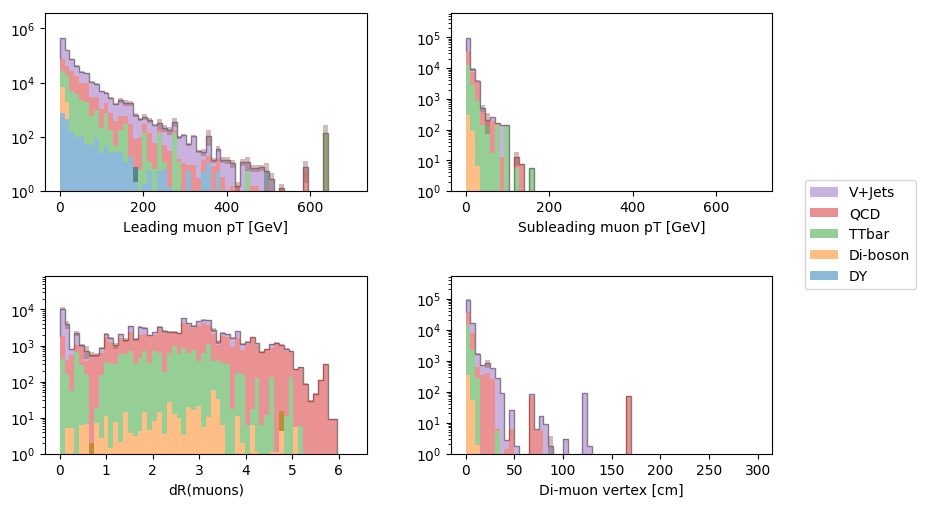

In [22]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_stacked_plot(axes2.flatten()[idx], var, 2, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

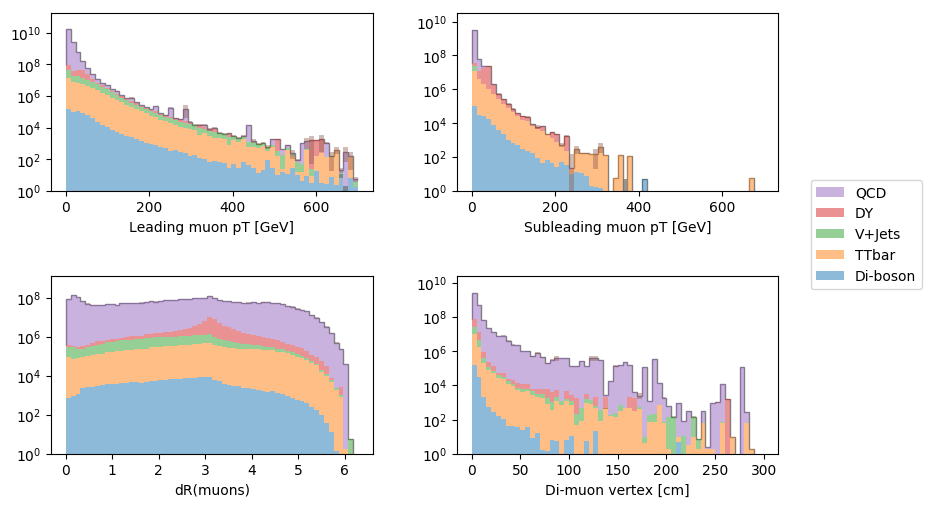

In [27]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_stacked_plot(axes2.flatten()[idx], var, 0, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

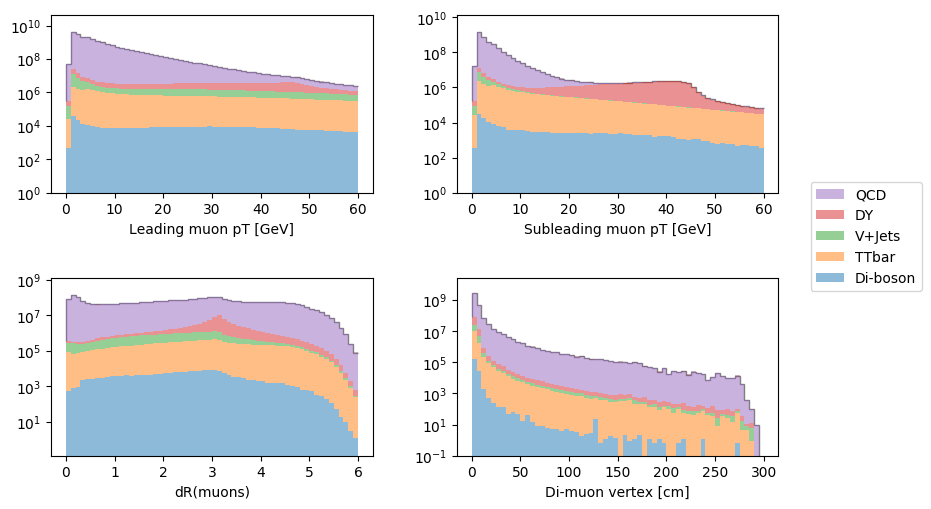

In [374]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_stacked_plot(axes2.flatten()[idx], var, 0, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

In [8]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

NameError: name 'plt' is not defined

In [ ]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));

# Displaced standalone muons

In [ ]:
with open('data/histos_objects_dsa.dat', 'rb') as histos_file:
    histos_from_file_dsa = pickle.load(histos_file)

In [ ]:
plt_maker = PM.PlotMaker(histos_from_file_dsa)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_metjet):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
axes1[0,1].legend(loc=(1.1,-0.55));

In [ ]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));